In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/train.csv", sep=",", encoding='utf-8', engine="python", escapechar="\\")
df.head()

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN


In [7]:
df["tags"].value_counts()

<UNIGRAM>                   347
<HI>                        169
<POLITICAL>                 134
<UNIGRAM> <NUMERAL>          82
<IRREGULAR_COLON_FORMAT>     13
<HI> <UNIGRAM>               10
Name: tags, dtype: int64

In [6]:
df["selfeval"][0] # Corresponds to empathy, relevance, and understandability by two different evaluators

'5|5|5_2|2|5'

In [3]:
import re
def valid_eval(selfeval: str) -> bool:
    """Returns true if given value have a valid format for self evaluation
    
    Args:
        selfeval (str): Candidate for self evaluation value.
    
    Returns:
        (bool): Validity for given self evaluation value
    """
    try:
        val = bool(re.match(r"^[0-5]\|[0-5]\|[0-5]_[0-5]\|[0-5]\|[0-5]$",selfeval))
    except TypeError:
        val = False
    return val
    
df_to_clean = df[~df["selfeval"].map(valid_eval)]
df_clean = df[df["selfeval"].map(valid_eval)]

In [4]:
selfeval_sep = df_clean["selfeval"].str.split("_")
selfeval_grouped = selfeval_sep.apply(lambda x: list(zip(x[0].split("|"),x[1].split("|"))))

empathy_vals = selfeval_grouped.apply(lambda x: x[0])
relevance_vals = selfeval_grouped.apply(lambda x: x[1])
understandability_vals = selfeval_grouped.apply(lambda x: x[2])

In [5]:
empathy_vals = pd.concat([empathy_vals.apply(lambda x: int(x[0])),empathy_vals.apply(lambda x: int(x[1]))], axis=0)
relevance_vals = pd.concat([relevance_vals.apply(lambda x: int(x[0])),relevance_vals.apply(lambda x: int(x[1]))], axis=0)
understandability_vals = pd.concat([understandability_vals.apply(lambda x: int(x[0])),understandability_vals.apply(lambda x: int(x[1]))], axis=0)

In [40]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})

<AxesSubplot:xlabel='selfeval', ylabel='Count'>

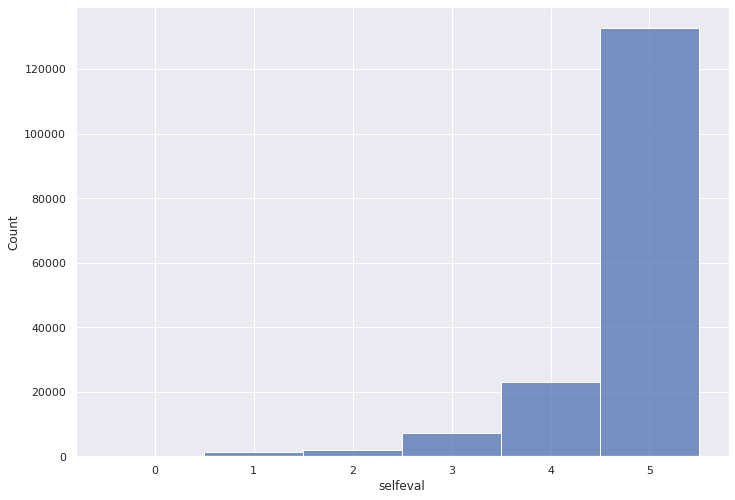

In [120]:
sns.histplot(empathy_vals, discrete=True)

In [20]:
empathy_vals.value_counts(normalize=True)

5    0.799755
4    0.138414
3    0.042623
2    0.011123
1    0.008036
0    0.000048
Name: selfeval, dtype: float64

<AxesSubplot:xlabel='selfeval', ylabel='Count'>

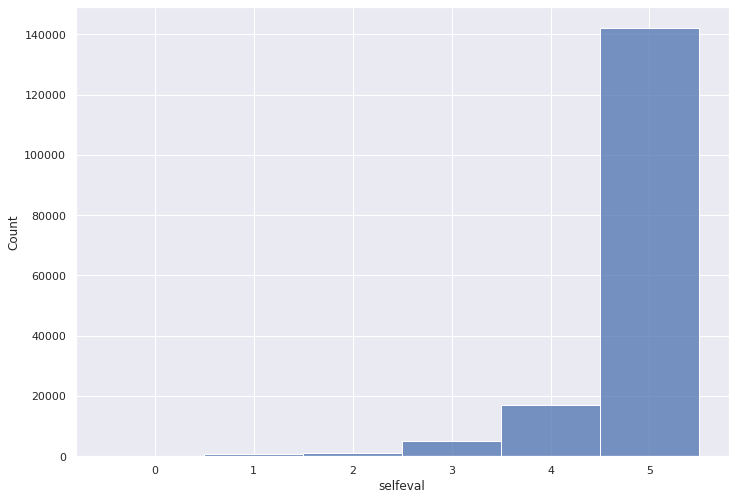

In [121]:
sns.histplot(relevance_vals, discrete=True)

<AxesSubplot:xlabel='selfeval', ylabel='Count'>

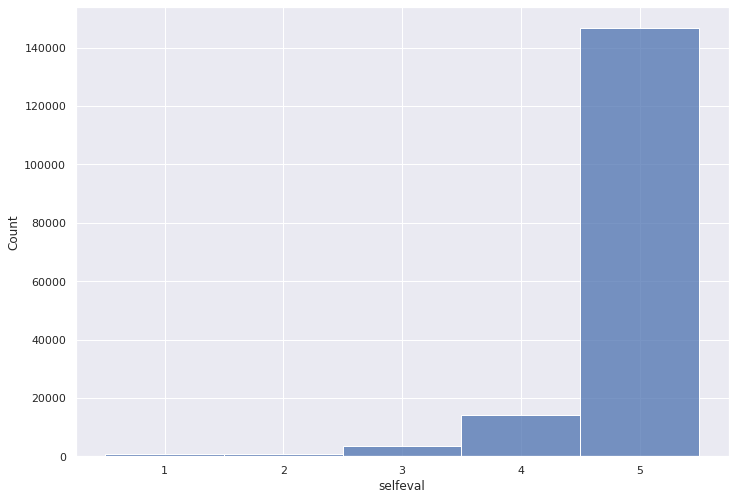

In [122]:
sns.histplot(understandability_vals, discrete=True)

<AxesSubplot:xlabel='Count', ylabel='context'>

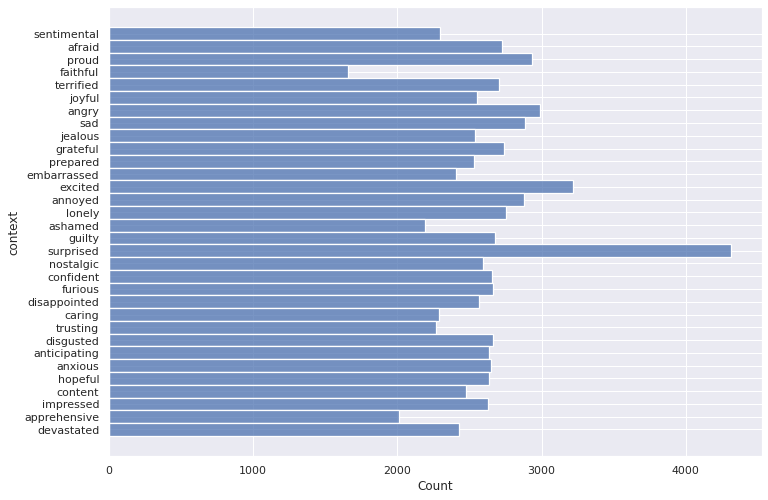

In [133]:
sns.histplot(df, y="context")

In [9]:
#df[df["conv_id"] == "hit:0_conv:1"]
df.iloc[:25]

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN
5,hit:0_conv:1,6,sentimental,I remember going to the fireworks with my best...,0,Oh was this something that happened because of...,5|5|5_2|2|5,NaN
6,hit:1_conv:2,1,afraid,i used to scare for darkness,2,it feels like hitting to blank wall when i se...,4|3|4_3|5|5,NaN
7,hit:1_conv:2,2,afraid,i used to scare for darkness,3,Oh ya? I don't really see how,4|3|4_3|5|5,NaN
8,hit:1_conv:2,3,afraid,i used to scare for darkness,2,dont you feel so.. its a wonder,4|3|4_3|5|5,NaN
9,hit:1_conv:2,4,afraid,i used to scare for darkness,3,I do actually hit blank walls a lot of times b...,4|3|4_3|5|5,NaN


## Filter emotion classification data

In [ ]:
root_speaker = {}
for ix, row in df[df["utterance_idx"] == 1][["conv_id", "speaker_idx"]].iterrows():
    root_speaker[row.conv_id] = row.speaker_idx


In [27]:
df_context = pd.DataFrame({"utterance": [], "context": []})
for conv_id, speaker_idx in root_speaker.items():
    sample = df[(df["conv_id"] == conv_id) & (df["speaker_idx"] == speaker_idx)][["utterance","context"]]
    df_context = pd.concat([df_context, sample], axis=0)

In [29]:
df_context.to_csv("data/preprocessed/emotion_detection.csv", index=False)

In [6]:
import pandas as pd
df_context = pd.read_csv("data/preprocessed/emotion_detection.csv")
df_context.head()

,utterance,context
0,I remember going to see the fireworks with my ...,sentimental
1,This was a best friend. I miss her.,sentimental
2,We no longer talk.,sentimental
3,it feels like hitting to blank wall when i se...,afraid
4,dont you feel so.. its a wonder,afraid


In [4]:
len(set(df_context["context"]))

32

In [7]:
df_context.shape

(43913, 2)

## Filter empathetic responses

In [10]:
df_clean.shape

(82936, 8)

In [11]:
df_clean.head()

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,NaN
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,NaN
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,NaN
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,NaN
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,NaN


In [25]:
selfeval_sep = df_clean["selfeval"].str.split("_")
selfeval_grouped = selfeval_sep.apply(lambda x: min(list(zip(x[0].split("|"),x[1].split("|")))[0]))

df_clean["selfeval_grouped"] = selfeval_grouped

<ipython-input-25-cc848f8d52b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["selfeval_grouped"] = selfeval_grouped


In [24]:
selfeval_grouped_diff = selfeval_sep.apply(lambda x: list(zip(x[0].split("|"),x[1].split("|")))[0])
diff_eval = selfeval_grouped_diff.apply(lambda x: abs(int(x[0]) - int(x[1])))
sum(diff_eval > 0)

27176

In [31]:
root_speaker = {}
for ix, row in df_clean[df_clean["utterance_idx"] == 2][["conv_id", "speaker_idx"]].iterrows():
    root_speaker[row.conv_id] = row.speaker_idx

In [32]:
df_empathetic = pd.DataFrame({"utterance": [], "context": []})
for conv_id, speaker_idx in root_speaker.items():
    sample = df_clean[(df_clean["conv_id"] == conv_id) & (df_clean["speaker_idx"] == speaker_idx)][["utterance","context", "selfeval_grouped"]]
    df_empathetic = pd.concat([df_empathetic, sample], axis=0)

In [33]:
df_empathetic.shape

(39674, 3)

In [46]:
df_empathetic.head()

,utterance,context,selfeval_grouped
1,Was this a friend you were in love with_comma_...,sentimental,2
3,Where has she gone?,sentimental,2
5,Oh was this something that happened because of...,sentimental,2
7,Oh ya? I don't really see how,afraid,3
9,I do actually hit blank walls a lot of times b...,afraid,3


<AxesSubplot:xlabel='selfeval_grouped', ylabel='Count'>

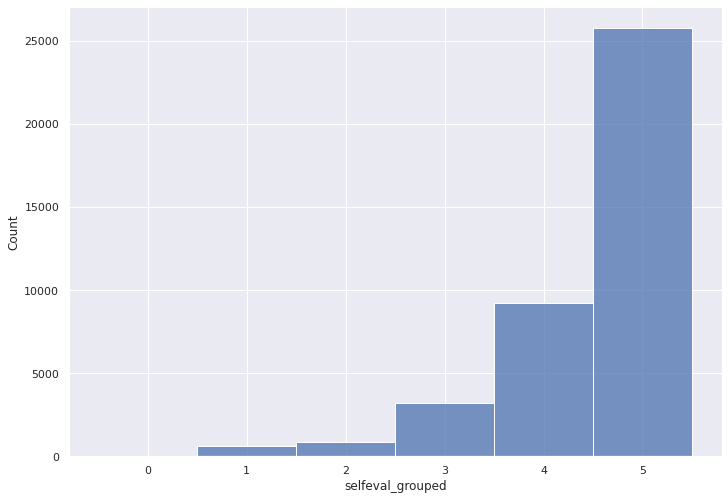

In [49]:
sns.histplot(df_empathetic["selfeval_grouped"], discrete=True)

In [47]:
df_empathetic.to_csv("data/preprocessed/empathy_assessment.csv", index=False)

In [1]:
import pandas as pd

df_empathetic = pd.read_csv("data/preprocessed/empathy_assessment.csv")
df_empathetic.head()

,utterance,context,selfeval_grouped
0,Was this a friend you were in love with_comma_...,sentimental,2
1,Where has she gone?,sentimental,2
2,Oh was this something that happened because of...,sentimental,2
3,Oh ya? I don't really see how,afraid,3
4,I do actually hit blank walls a lot of times b...,afraid,3


In [5]:
max_val = df_empathetic["selfeval_grouped"] == 5
max_val.value_counts(normalize=True)

True     0.649317
False    0.350683
Name: selfeval_grouped, dtype: float64